**Group information**

| Family name | First name | Email address |
| ----------- | ---------- | ------------- |
| Vollmer     |Alessandra  | vollmeralessandra@yahoo.de|
|             |            |               |
|             |            |               |

# Images - Solutions

In this tutorial we explore how computer vision models can be used to predict emotions from facial images. The labelled dataset available on [Kaggle](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset) contains 35,887 images of dimensions $48 \times 48 \times 3$, representing faces expressing 7 fundamental emotions including anger, disgust, fear, happiness, neutral, sadness, and surprise. We aim to approximate the function mapping each image to a set of conditional probabilities corresponding to each emotion using a simple convolutional neural network.

Tensorflow Keras documentation:
- [Convolution](https://keras.io/api/layers/convolution_layers/)
- [Activation](https://keras.io/api/layers/activations/)
- [Pooling](https://keras.io/api/layers/pooling_layers/)
- [Regularisation](https://keras.io/api/layers/regularization_layers/)
- [Optimisers](https://keras.io/api/optimizers/)
- [Metrics](https://keras.io/api/metrics/)
- [Losses](https://keras.io/api/losses/)
- [Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

In [ ]:
# Packages
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
import os
import shutil

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import callbacks, datasets, initializers, layers, losses, models, optimizers, preprocessing, utils
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, Input, Conv2D, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from urllib import request


# Makes results reproducible
np.random.seed(0)

In [ ]:
# Utilities
emotions = np.array(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise'])

def display_image(image:np.ndarray, title:str='') -> None:
    '''Displays an image'''
    fig, ax = pyplot.subplots(figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    ax.set_title(title, fontsize=15)
    ax.set_axis_off()
    pyplot.tight_layout()
    pyplot.show()

def display_history(history:dict, statistic:str='loss') -> None:
    '''Displays training history for a statistic'''
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(history[statistic], label='Training sample')
    if f'val_{statistic}' in history:
        ax.plot(history[f'val_{statistic}'], label='Validation sample')
    ax.set_title(f'Model training', fontsize=15)
    ax.set_ylabel(statistic.title())
    ax.set_xlabel('Epoch')
    ax.legend(frameon=False)
    pyplot.tight_layout()
    pyplot.show()

def download_data():
    '''Downloads data folder'''
    request.urlretrieve('https://www.dropbox.com/scl/fo/3fud31xwpqg9whg00h8f8/h?rlkey=5bxqonzq9ny5y78sr11kgtjwp&dl=1', 'data.zip')
    shutil.unpack_archive('data.zip', 'data')
    os.remove('data.zip')
    os.chdir('data')

1. Load the images and labels using the provided code.

In [ ]:
# Loads dataset
download_data() # On first execution
images = np.load('images.npy')
labels = np.load('labels.npy')

2. Display a sample of images and labels using the provided `display_image` function. Check the dimension of the images and compute label frequencies.

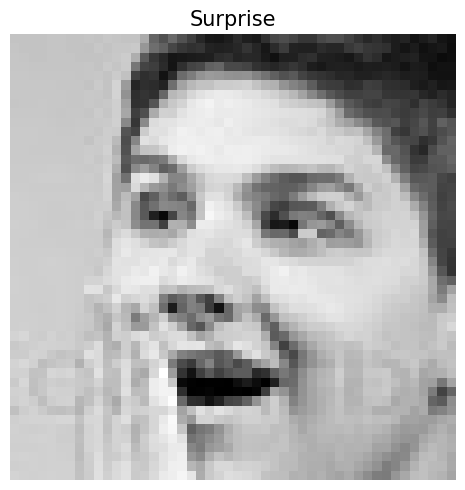

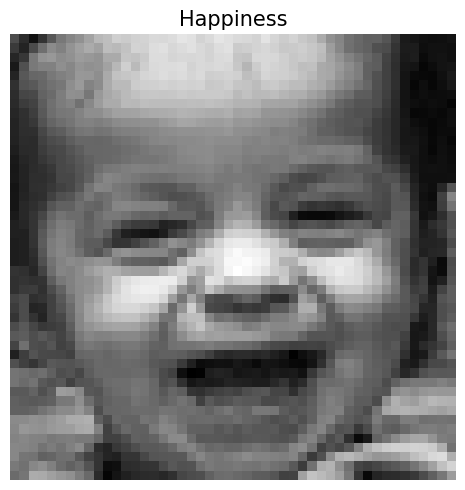

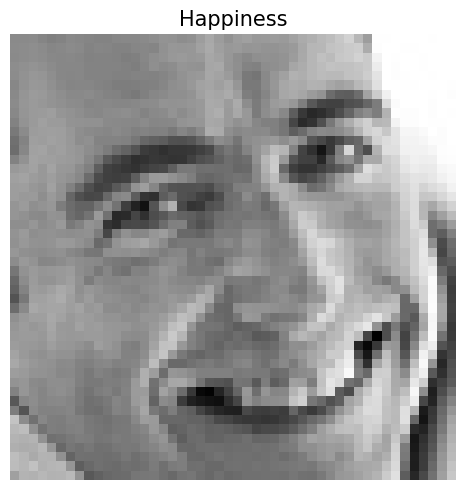

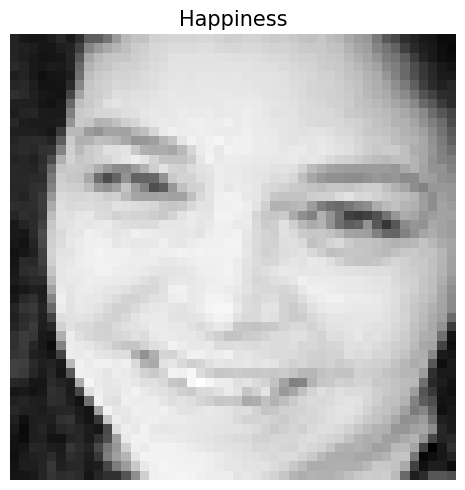

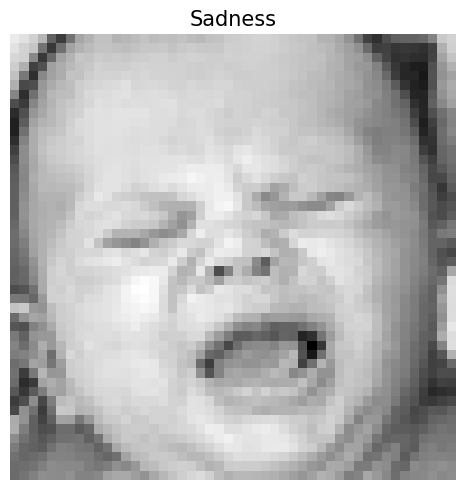

Image Dimensions: (35887, 48, 48, 1)
Label Frequencies: {'Anger': 4953, 'Disgust': 547, 'Fear': 5121, 'Happiness': 8989, 'Neutral': 6198, 'Sadness': 6077, 'Surprise': 4002}


In [ ]:
# Display sample images
sample_indices = np.random.choice(images.shape[0], 5, replace=False)
for idx in sample_indices:
    display_image(images[idx], title=labels[idx])

# Check the dimension of the images
image_dimension = images.shape

# Compute label frequencies
unique, counts = np.unique(labels, return_counts=True)
label_frequencies = dict(zip(unique, counts))

print("Image Dimensions:", image_dimension)
print("Label Frequencies:", label_frequencies)

3. Format the labels for multi-class classification, that is a binary numpy array of type float with dimensions $n \times n_{emotions}$  (i.e. we are predicting probabilities for each class).

In [ ]:
# Convert string labels to integers
label_to_int = {emotion: i for i, emotion in enumerate(emotions)}
int_labels = np.array([label_to_int[label] for label in labels])

# One-hot encode the integer labels
encoded_labels = to_categorical(int_labels, num_classes=len(emotions))

# Display the shape of the encoded labels
print("Shape of encoded labels:", encoded_labels.shape)

Shape of encoded labels: (35887, 7)


4. Randomly partition the dataset into a training (75%) and a test (25%) sample.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.25, random_state=42)

# Check the shape of the resulting arrays
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (26915, 48, 48, 1)
Test data shape: (8972, 48, 48, 1)
Training labels shape: (26915, 7)
Test labels shape: (8972, 7)


5. Using the Keras functional API, define a simple convolutional network with the following structure:

- An input layer
- Four blocks of layers with $d = 8, 16, 32, 64$ convolutional filters, respectively:
    - Convolution: $d$ filters of size of $3 \times 3$, same padding
    - Activation: ReLU
    - Pooling: $2 \times 2$, maximum
- A global average pooling layer
- A dense output layer with the appropriate activation function

Call either the `summary` method of the model or `utils.plot_model` to verify the structure.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 8)         80        
                                                                 
 re_lu_4 (ReLU)              (None, 48, 48, 8)         0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 re_lu_5 (ReLU)              (None, 24, 24, 16)        0         
                                                           

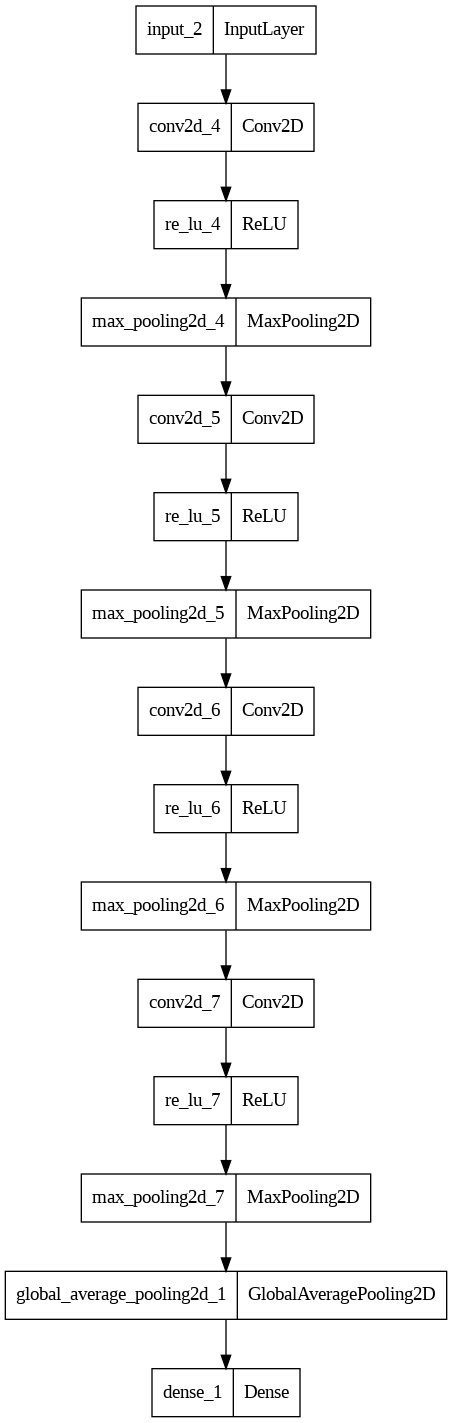

In [ ]:
input_shape = (48, 48, 1)

# Define the input layer
inputs = Input(shape=input_shape)

# Block 1
x = Conv2D(8, (3, 3), padding='same')(inputs)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Block 2
x = Conv2D(16, (3, 3), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Block 3
x = Conv2D(32, (3, 3), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Block 4
x = Conv2D(64, (3, 3), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Dense output layer with softmax activation for multi-class classification
outputs = Dense(len(emotions), activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Model summary
model.summary()

#To visualise the model
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

6. Compile the model to define the appropriate loss function and an optimisation algorithm.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

7. Estimate the model parameters using the training sample and a maximum of 100 training epochs. After training, use the provided `display_history` function to visualise the optimisation path.

In [ ]:
# Create an EarlyStopping callback instance to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/100
673/673 [==============================] - 35s 48ms/step - loss: 2.0323 - accuracy: 0.2483 - val_loss: 1.7517 - val_accuracy: 0.3054
Epoch 2/100
673/673 [==============================] - 36s 54ms/step - loss: 1.6837 - accuracy: 0.3364 - val_loss: 1.6750 - val_accuracy: 0.3643
Epoch 3/100
673/673 [==============================] - 33s 49ms/step - loss: 1.5834 - accuracy: 0.3889 - val_loss: 1.5961 - val_accuracy: 0.3892
Epoch 4/100
673/673 [==============================] - 40s 60ms/step - loss: 1.5125 - accuracy: 0.4226 - val_loss: 1.5450 - val_accuracy: 0.4054
Epoch 5/100
673/673 [==============================] - 32s 47ms/step - loss: 1.4513 - accuracy: 0.4449 - val_loss: 1.4939 - val_accuracy: 0.4377
Epoch 6/100
673/673 [==============================] - 51s 76ms/step - loss: 1.4014 - accuracy: 0.4690 - val_loss: 1.5513 - val_accuracy: 0.4239
Epoch 7/100
673/673 [==============================] - 37s 55ms/step - loss: 1.3512 - accuracy: 0.4885 - val_loss: 1.4508 - val_ac

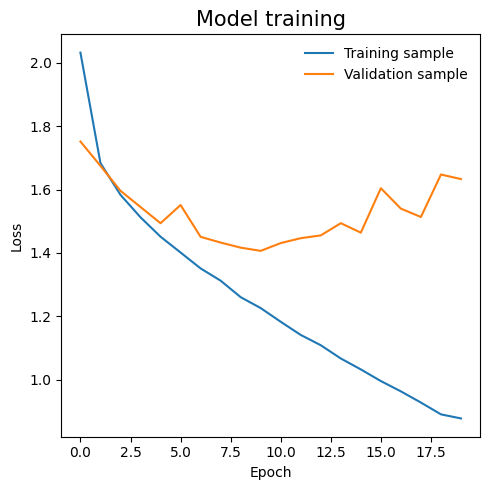

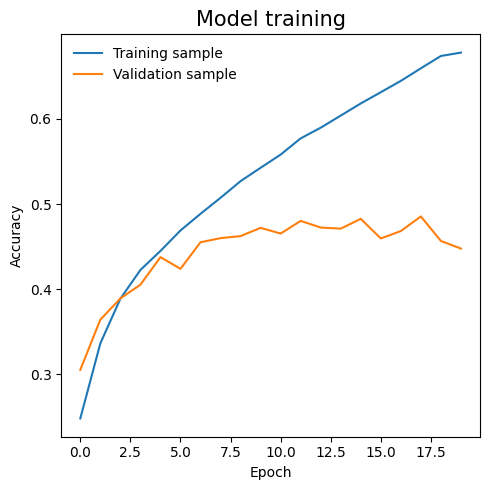

In [ ]:
display_history(history.history, statistic='loss')
display_history(history.history, statistic='accuracy')

 8. Evaluate the model's generalisation performance on the test sample.

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

281/281 [==============================] - 4s 15ms/step - loss: 1.3879 - accuracy: 0.4855
Test Loss: 1.3879485130310059
Test Accuracy: 0.4855104684829712


9. Display a sample of test predictions and compute a confusion matrix. Comment on the results.

281/281 [==============================] - 5s 19ms/step


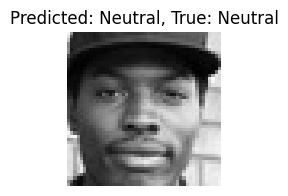

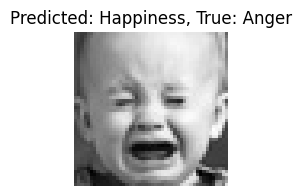

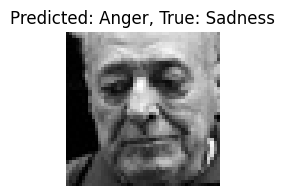

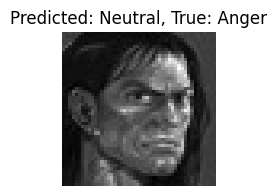

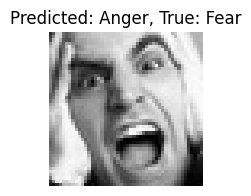

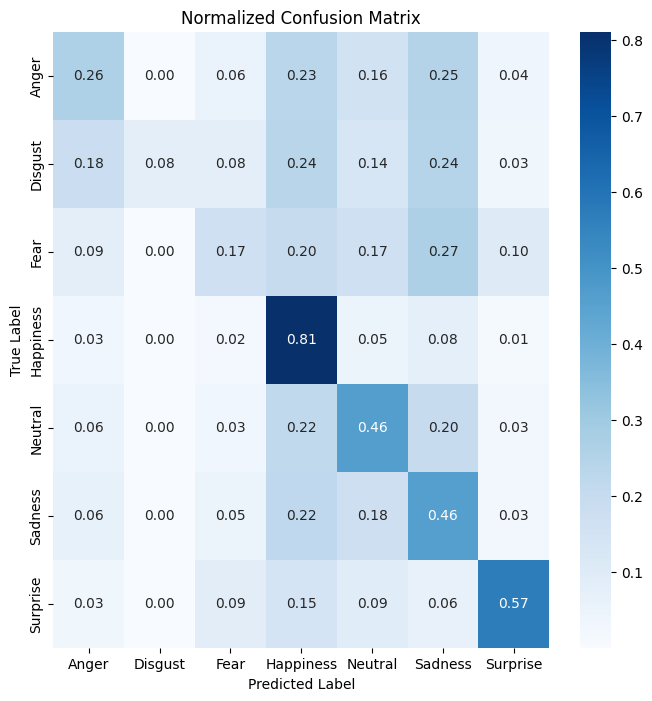

In [ ]:
# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Display a sample of test images, their predicted labels, and true labels
sample_indices = np.random.choice(np.arange(len(X_test)), 5, replace=False)
for idx in sample_indices:
    plt.figure(figsize=(2, 2))
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"Predicted: {emotions[predicted_classes[idx]]}, True: {emotions[true_classes[idx]]}")
    plt.axis('off')
    plt.show()

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Comment on results
The model's accuracy on both the training and validation sets improves over the first 10 epochs, indicating that the model is learning and adapting to the training data. However, after around the 10th epoch, the model's validation accuracy begins to plateau and even decrease slightly, suggesting that it might be starting to overfit to the training data. The best validation accuracy observed is around 47.2%, achieved at epoch 10. This indicates the model's best performance on data it hasn't seen during training. However, the performance is not particularly high, suggesting that the model struggles to generalize well to unseen data.

As the training progressed past the 10th epoch, the training loss began to decrease more significantly compared to the validation loss, indicating the onset of overfitting.
The model is learning to perform well on the training data, possibly memorizing it, but fails to generalize these learnings effectively to new data. This is a clear sign that the model was starting to memorize the training data, impairing its ability to generalize to new, unseen data. Implementing early stopping, as seen in the training log, was a good decision to prevent the model from overfitting further.

Looking at the confusion matrix, the model demonstrates strong performance in recognizing 'Happy' with a normalised score of 0.81. 'Neutral' and 'Surprise' emotions are reasonably classified, with scores of 0.46 and 0.57, respectively. Although not as high as 'Happiness', the model still manages to capture these emotions more than half the time correctly. There are notable confusions between 'Anger', 'Fear', and 'Sadness'. It appears that the model often misclassifies 'Anger' as 'Sadness' and 'Fear' as 'Sadness'. This could be due to similarities in facial expressions for these emotions or a lack of distinct features learned by the model for these classes. 'Disgust' is poorly classified, with no predictions strongly leaning towards it (the highest value in the 'Disgust' column is 0.24 for predicting 'Fear' when the true label is 'Disgust'). This suggests that 'Disgust' may not have been represented adequately in the training data, or it is an emotion that is more complex for the model to distinguish.

The matrix indicates a bias towards certain classes like 'Happiness' and 'Neutral', which might be due to a larger representation of these emotions in the training set, or that they have more distinguishable features. The spread across the matrix for 'Anger', 'Fear', and 'Sadness' indicates a level of uncertainty or confusion for the model when classifying these emotions.


10. Modify the model structure and/or training procedure to increase predictive performance.

In [ ]:
# Define the input shape
input_shape = (48, 48, 1)

# Define the input layer
inputs = Input(shape=input_shape)

# Block 1
x = Conv2D(64, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Block 2
x = Conv2D(128, (5, 5), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Block 3
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Block 4
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Flattening
x = Flatten()(x)

# Fully connected layer 1st layer
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

# Fully connected layer 2nd layer
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

# Output Layer
outputs = Dense(len(emotions), activation='softmax')(x)

# Create the model
model2 = Model(inputs=inputs, outputs=outputs)

# Compilation
model2.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Track accuracy
)


**Bonus**: Run the model prediction on a custom image.

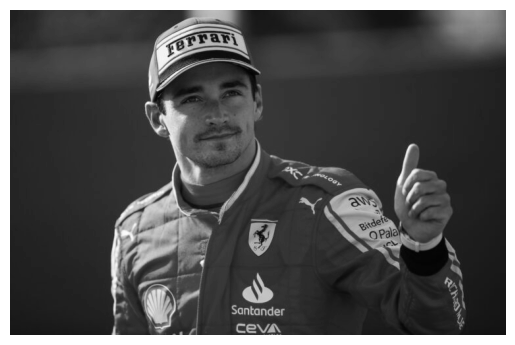

1/1 [==============================] - 0s 54ms/step
The predicted emotion is: Neutral


In [ ]:
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model


# URL of the image
image_url = "https://www.autohebdo.fr/app/uploads/2023/10/DPPI_00123032_852-753x494.jpg"

# Send an HTTP GET request to the image URL
response = requests.get(image_url)

# Open the image directly from the HTTP response
img = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale ('L')
# Display the image before preprocessing
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
# Resize the image to match the model's expected input size
img = img.resize((48, 48))

# Convert the image to a numpy array and scale the pixel values to [0, 1]
img_array = img_to_array(img) / 255.0

# Expand dimensions to match the model's input format
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions2 = model2.predict(img_array)

# Interpret the prediction
predicted_class = np.argmax(predictions2)
emotion = emotions[predicted_class]

print(f"The predicted emotion is: {emotion}")